In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

## 1- Load data 

In [2]:
df = pd.read_csv(r"C:\Users\HP\Downloads\online_retail_II.csv\online_retail_II.csv")

## 2-Debugging: Check initial data types

In [3]:
print("Initial Data Types:")
print(df.dtypes)


Initial Data Types:
Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object



## 3- Data cleaning

In [4]:
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df = df[~df['Customer ID'].isna()]
df = df[~df['Invoice'].astype(str).str.startswith('C')]  # Remove cancellations
df['Customer ID'] = df['Customer ID'].astype(int)


## 4- Convert InvoiceDate to datetime, coerce invalid values to NaT

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

## 5- Debugging: Check for NaT values and data types after conversion

In [6]:
print("\nNaT Values in InvoiceDate:", df['InvoiceDate'].isna().sum())
print("Data Types After Conversion:")
print(df.dtypes)



NaT Values in InvoiceDate: 0
Data Types After Conversion:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID             int32
Country                object
dtype: object


## 6- Remove rows with NaT in InvoiceDate

In [8]:
df = df[~df['InvoiceDate'].isna()]

## 7- # Calculate TotalPrice

In [9]:
df['TotalPrice'] = df['Quantity'] * df['Price']

## 8- Reference date for Recency

In [10]:
current_date = dt.datetime(2011, 12, 10)

## 9-Calculate RFM metrics

In [11]:
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency (unique invoices)
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

## 10- Debugging: Check RFM DataFrame

In [12]:
print("\nRFM DataFrame (first 5 rows):")
print(rfm.head())

# Assign scores using quintiles (handle ties for Frequency)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')


RFM DataFrame (first 5 rows):
             Recency  Frequency  Monetary
Customer ID                              
12346            325         12  77556.46
12347              2          8   5633.32
12348             75          5   2019.40
12349             18          4   4428.69
12350            310          1    334.40



## 11- Combine scores

In [13]:
rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

## 12- Define customer segments

In [14]:
def rfm_segment(row):
    r = int(row['R_score'])
    f = int(row['F_score'])
    m = int(row['M_score'])
    if r in [4, 5] and f in [4, 5] and m in [4, 5]:
        return 'Champions'
    elif r in [3, 4, 5] and f in [3, 4, 5] and m in [3, 4, 5]:
        return 'Loyal Customers'
    elif r in [4, 5] and f in [2, 3] and m in [2, 3, 4, 5]:
        return 'Potential Loyalists'
    elif r == 5 and f == 1:
        return 'New Customers'
    elif r in [3, 4] and f == 1:
        return 'Promising'
    elif r in [2, 3] and f in [2, 3] and m in [2, 3]:
        return 'Need Attention'
    elif r in [1, 2] and f in [3, 4, 5] and m in [3, 4, 5]:
        return 'At Risk'
    elif r in [1, 2] and f in [1, 2] and m in [1, 2]:
        return 'Lost'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

## 13- Display RFM table (first 10 for brevity)

In [15]:
print("\nRFM Analysis (first 10 customers):")
print(rfm.head(10))


RFM Analysis (first 10 customers):
             Recency  Frequency  Monetary R_score F_score M_score RFM_score  \
Customer ID                                                                   
12346            325         12  77556.46       2       5       5       255   
12347              2          8   5633.32       5       4       5       545   
12348             75          5   2019.40       3       4       4       344   
12349             18          4   4428.69       5       3       5       535   
12350            310          1    334.40       2       1       2       212   
12351            375          1    300.93       2       1       2       212   
12352             36         10   2849.84       4       5       4       454   
12353            204          2    406.76       2       2       2       222   
12354            232          1   1079.40       2       1       3       213   
12355            214          2    947.61       2       2       3       223   

               

## 14- Segment distribution

In [16]:
print("\nSegment Counts:")
print(rfm['Segment'].value_counts())


Segment Counts:
Segment
Champions              1294
Lost                   1151
Loyal Customers        1143
Need Attention          574
Others                  542
At Risk                 501
Potential Loyalists     313
Promising               304
New Customers            56
Name: count, dtype: int64


# 15-Descriptive statistics

In [17]:
print("\nDescriptive Statistics:")
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())


Descriptive Statistics:
           Recency    Frequency       Monetary
count  5878.000000  5878.000000    5878.000000
mean    200.866791     6.289384    3018.616737
std     209.353961    13.009406   14737.731040
min       0.000000     1.000000       2.950000
25%      25.000000     1.000000     348.762500
50%      95.000000     3.000000     898.915000
75%     379.000000     7.000000    2307.090000
max     738.000000   398.000000  608821.650000


# 16- Average RFM per segment for heatmap

In [19]:
segment_rfm = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nAverage RFM per Segment:")
print(segment_rfm)




Average RFM per Segment:
                        Recency  Frequency     Monetary
Segment                                                
At Risk              370.736527   6.179641  2882.780802
Champions             19.273570  17.122102  9354.323451
Lost                 483.284101   1.132059   238.798202
Loyal Customers       73.155731   5.948381  2300.813365
Need Attention       250.994774   2.344948   606.160437
New Customers         10.303571   1.000000   356.257857
Others               282.149446   2.267528   790.598197
Potential Loyalists   25.846645   2.172524  1198.291214
Promising             80.513158   1.000000   389.865592


# 17- Visualizations

In [20]:
sns.set(style="whitegrid")

# 18- Bar chart for segment distribution

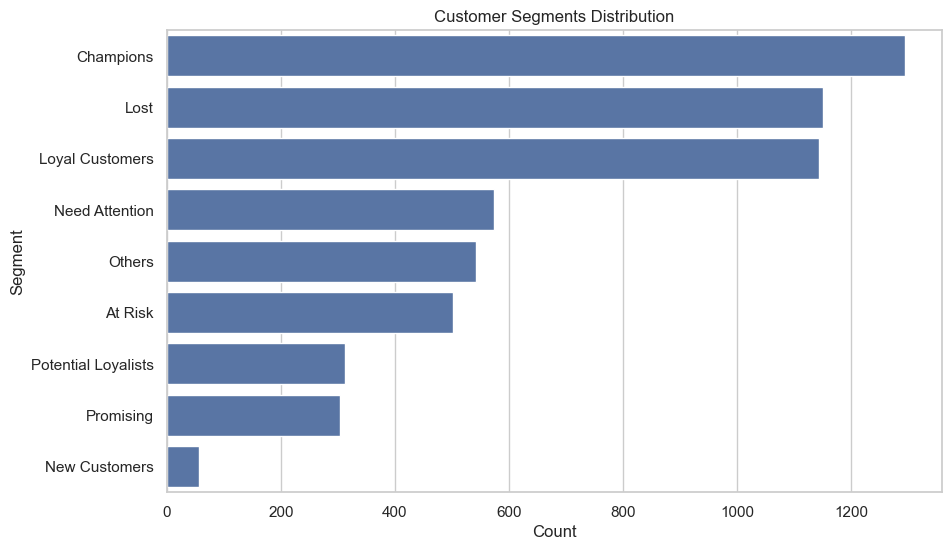

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Distribution')
plt.xlabel('Count')
plt.ylabel('Segment')
plt.show()


# 19- Heatmap for average RFM values per segment

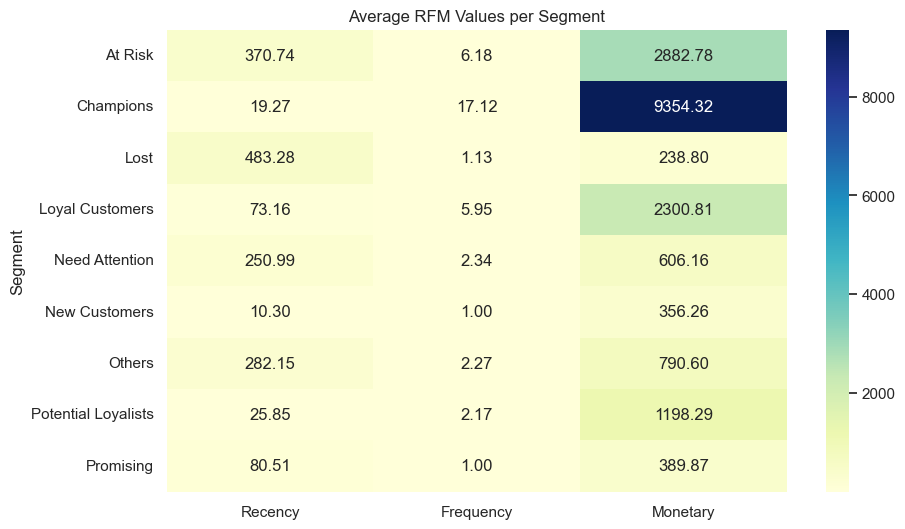

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(segment_rfm, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Average RFM Values per Segment')
plt.show()